## HW4
## name: Peter Xu
## github username: peterxxu
## USC ID: 7582896983

## 1.a: download and import

In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from scipy.stats import bootstrap
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.metrics import confusion_matrix, RocCurveDisplay, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.utils import resample

from sklearn.naive_bayes import GaussianNB, MultinomialNB

import statsmodels.api as sm

## 1.b: setup train and test data

In [2]:
# read files programmatically
train_df = pd.DataFrame()
test_df = pd.DataFrame()

# record all files needed for training data
base_dir = '../data/activity+recognition+system+based+on+multisensor+data+fusion+arem'
folders_files_map = {
    'bending1': ['dataset1', 'dataset2'],
    'bending2': ['dataset1', 'dataset2'],
    'cycling': ['dataset1', 'dataset2', 'dataset3'],
    'lying': ['dataset1', 'dataset2', 'dataset3'],
    'sitting': ['dataset1', 'dataset2', 'dataset3'],
    'standing': ['dataset1', 'dataset2', 'dataset3'],
    'walking': ['dataset1', 'dataset2', 'dataset3'],
}
for folder, datasets in folders_files_map.items():
    # read all files from all folders
    folder_path = os.path.join(base_dir, folder)
    all_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

    # build test data on specified file names
    for dataset in datasets:
        file_name = f'{dataset}.csv'
        if file_name in all_files:
            file_path = os.path.join(folder_path, file_name)
            # print(file_path)
            curr_test_df = pd.read_csv(file_path, skiprows=4).rename(columns={'# Columns: time': 'time'})
            test_df = pd.concat([test_df, curr_test_df], axis=0)
            # remove read file to prepare for test df
            all_files.remove(file_name)
    # build train data on remaining files
    for file_name in all_files:
        file_path = os.path.join(folder_path, file_name)
        # print('test:', file_path)
        # dataset 4 in bending 2 is space separated, so read accordingly
        if 'bending2/dataset4' in file_path:
            curr_train_df = pd.read_csv(file_path, sep='\s+', skiprows=5, names=['time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23'])
        else:
            curr_train_df = pd.read_csv(file_path, skiprows=4).rename(columns={'# Columns: time': 'time'}) # format the df
        train_df = pd.concat([train_df, curr_train_df], axis=0)

In [3]:
train_df

,time,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23
0,0,42.00,0.00,18.50,0.50,12.00,0.00
1,250,42.00,0.00,18.00,0.00,11.33,0.94
2,500,42.75,0.43,16.75,1.79,18.25,0.43
3,750,42.50,0.50,16.75,0.83,19.00,1.22
4,1000,43.00,0.82,16.25,0.83,18.00,0.00
...,...,...,...,...,...,...,...
475,118750,31.50,1.66,12.50,3.20,14.25,4.44
476,119000,27.33,1.25,11.33,0.94,20.00,4.00
477,119250,37.80,7.68,14.20,2.48,17.25,0.83
478,119500,33.75,1.30,15.75,5.21,16.50,2.69


In [4]:
test_df

,time,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23
0,0,39.25,0.43,22.75,0.43,33.75,1.30
1,250,39.25,0.43,23.00,0.00,33.00,0.00
2,500,39.25,0.43,23.25,0.43,33.00,0.00
3,750,39.50,0.50,23.00,0.71,33.00,0.00
4,1000,39.50,0.50,24.00,0.00,33.00,0.00
...,...,...,...,...,...,...,...
475,118750,36.00,2.45,17.00,5.10,20.50,0.87
476,119000,34.33,1.89,15.00,2.45,17.00,2.12
477,119250,33.00,7.35,14.60,3.14,13.00,5.70
478,119500,31.67,1.25,11.00,6.16,19.25,2.17


## 1.c: feature extraction

### 1.c.i: common time-domain features

mean, median, standard deviation, variance, minimum, maximum, skewness, range, quantiles

### 1.c.ii: extract time-domain features for each instance

In [5]:
# empty list to store all time-domain features (each element is a dict of an instance features)
time_domain_features = []
folders = list(folders_files_map.keys())
instance_count = 1
# iterate through all files in each folder
for folder in folders:
    folder_path = os.path.join(base_dir, folder)
    for file in os.listdir(folder_path):
        if file.endswith('.csv'):
            file_path = os.path.join(folder_path, file)
            # print(instance_count, file_path)
            # read csv file and handle space separated file
            if 'bending2/dataset4' in file_path:
                curr_df = pd.read_csv(file_path, sep='\s+', skiprows=5, names=['time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23'])
            else:
                curr_df = pd.read_csv(file_path, skiprows=4).rename(columns={'# Columns: time': 'time'}) # format the df
            curr_df.drop(columns='time', inplace=True)

            # create time domain feature dictionary to store features for instance
            curr_time_domain_feature = {'Instance': instance_count}
            # iterate through each column in current file
            for col in curr_df.columns:
                col_features = {
                    f'{col}_min': curr_df[col].min(),
                    f'{col}_max': curr_df[col].max(),
                    f'{col}_mean': curr_df[col].mean(),
                    f'{col}_median': curr_df[col].median(),
                    f'{col}_std': curr_df[col].std(),
                    f'{col}_q1': curr_df[col].quantile(0.25),
                    f'{col}_q3': curr_df[col].quantile(0.75),
                }
                # update current feature dict with current column features
                curr_time_domain_feature.update(col_features)
                
            # append current time domain feature to the features list
            time_domain_features.append(curr_time_domain_feature)
            # increment instance count
            instance_count += 1
# create time domain feature dataframe from the list of dictionary of features
features_df = pd.DataFrame(time_domain_features)
features_df

,Instance,avg_rss12_min,avg_rss12_max,avg_rss12_mean,avg_rss12_median,avg_rss12_std,avg_rss12_q1,avg_rss12_q3,var_rss12_min,var_rss12_max,...,avg_rss23_std,avg_rss23_q1,avg_rss23_q3,var_rss23_min,var_rss23_max,var_rss23_mean,var_rss23_median,var_rss23_std,var_rss23_q1,var_rss23_q3
0,1,36.25,48.00,43.969125,44.500,1.618364,43.31,44.67,0.0,1.50,...,3.318301,20.5000,23.75,0.00,2.96,0.555312,0.490,0.487826,0.0000,0.8300
1,2,37.00,48.00,43.454958,43.250,1.386098,42.50,45.00,0.0,1.58,...,2.488862,22.2500,24.00,0.00,5.26,0.679646,0.500,0.622534,0.4300,0.8700
2,3,33.00,47.75,42.179812,43.500,3.670666,39.15,45.00,0.0,3.00,...,3.849448,30.4575,36.33,0.00,2.18,0.613521,0.500,0.524317,0.0000,1.0000
3,4,33.00,45.75,41.678063,41.750,2.243490,41.33,42.75,0.0,2.83,...,2.411026,28.4575,31.25,0.00,1.79,0.383292,0.430,0.389164,0.0000,0.5000
4,5,37.25,45.00,40.624792,40.500,1.476967,39.25,42.00,0.0,1.30,...,2.188449,33.0000,36.00,0.00,1.92,0.570583,0.430,0.582915,0.0000,1.3000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,84,19.75,45.50,34.322750,35.250,4.752477,31.00,38.00,0.0,13.47,...,3.119856,13.5000,17.75,0.00,9.67,3.432563,3.200,1.732727,2.1575,4.5650
84,85,19.25,44.00,34.473188,35.000,4.796705,31.25,38.00,0.0,13.86,...,3.156320,13.7300,17.75,0.43,9.00,3.340458,3.090,1.699114,2.1200,4.3750
85,86,23.50,46.25,34.873229,35.250,4.531720,31.75,38.25,0.0,14.82,...,3.131076,13.7500,18.00,0.00,9.51,3.424646,3.270,1.690960,2.1700,4.5000
86,87,18.33,45.75,34.599875,35.125,4.731790,31.50,38.00,0.0,15.37,...,2.905688,14.0000,18.25,0.00,8.86,3.289542,3.015,1.680170,2.1200,4.2600


### 1.c.iii: standard deviations for time-domain features

In [6]:
# stds
std_features_df = pd.DataFrame(features_df.drop(columns='Instance').std(), columns=['std'])

In [7]:
# define CI level and bootstrap sample time
n = 1000
ci = 0.9

# 90% bootstrap confidence interval
confidence_intervals = []
for col in features_df.drop(columns='Instance'):
    # manual sample with replacement from each feature and calculate std
    sample_stds = []
    for i in range(n):
        sample_std = features_df[col].sample(n=len(features_df[col]), replace=True).std()
        sample_stds.append(sample_std)
        
    # calculate 90% using percentile
    sample_stds = np.array(sample_stds)
    lower_bound = np.percentile(sample_stds, ((1-ci) / 2) * 100)
    upper_bound = np.percentile(sample_stds, (1 - ((1-ci) / 2)) * 100)
    confidence_intervals.append([lower_bound, upper_bound])
    

# format CI to dataframe
std_features_df['90%_bootstrap_ci'] = confidence_intervals
std_features_df

,std,90%_bootstrap_ci
avg_rss12_min,9.569975,"[8.220753248399856, 10.81584811246447]"
avg_rss12_max,4.394362,"[3.353547608447107, 5.228238213575821]"
avg_rss12_mean,5.335718,"[4.685701536761012, 5.874840900176608]"
avg_rss12_median,5.440054,"[4.766380934954395, 5.984405712820439]"
avg_rss12_std,1.772153,"[1.5670870348451251, 1.9472440415775294]"
avg_rss12_q1,6.153590,"[5.551589724913199, 6.6495229665701]"
avg_rss12_q3,5.138925,"[4.348735566129749, 5.852809833587933]"
var_rss12_min,0.000000,"[0.0, 0.0]"
var_rss12_max,5.062729,"[4.60986115429084, 5.39148287981367]"
var_rss12_mean,1.574164,"[1.3936563409167133, 1.7086688818999318]"


### 1.c.iv: three most important time-domain features

Mean, std, and max. Mean can an important feature because it's sensitive to the spread of the data, which can be a good indicator to distinguish different human activities. Max can also be important because they define the range of a feature, which can be distinct for different human activities. Stand deviation helps to see variabilities in data, which may differ for different activities.

## 2. time series binary and multiclass classification

### 2.a: binary classification with logistic regression

#### 2.a.i: scatter plot

In [8]:
# features: mean, std, max for avg_rss_12, var_rss_12, ar_rss_23 - in total 9 features
# manually keep track of what instances are training and what instances are testing
testing_instances = [5, 6, 11, 12, 18, 19, 20, 33, 34, 35, 48, 49, 50, 63, 64, 65, 78, 79, 80]
training_instances = [i for i in range(1, 89) if i not in testing_instances]

bending_train_instances = [1, 2, 3, 4, 7, 8, 9, 10, 13]
nonbend_train_instances = [i for i in training_instances if i not in bending_train_instances]

bending_test_instances = [5, 6, 11, 12]
nonbend_test_instances = [i for i in testing_instances if i not in bending_test_instances]

# select features to plot
time_series_features = ['avg_rss12_std', 'avg_rss12_max', 'avg_rss12_mean', 'var_rss12_std', 'var_rss12_max', 'var_rss12_mean', 'var_rss23_std', 'var_rss23_max', 'var_rss23_mean']

# create df for train bending and nonbending
df_bending_train = features_df.loc[features_df['Instance'].isin(bending_train_instances), time_series_features]
df_nonbending_train = features_df.loc[features_df['Instance'].isin(nonbend_train_instances), time_series_features]

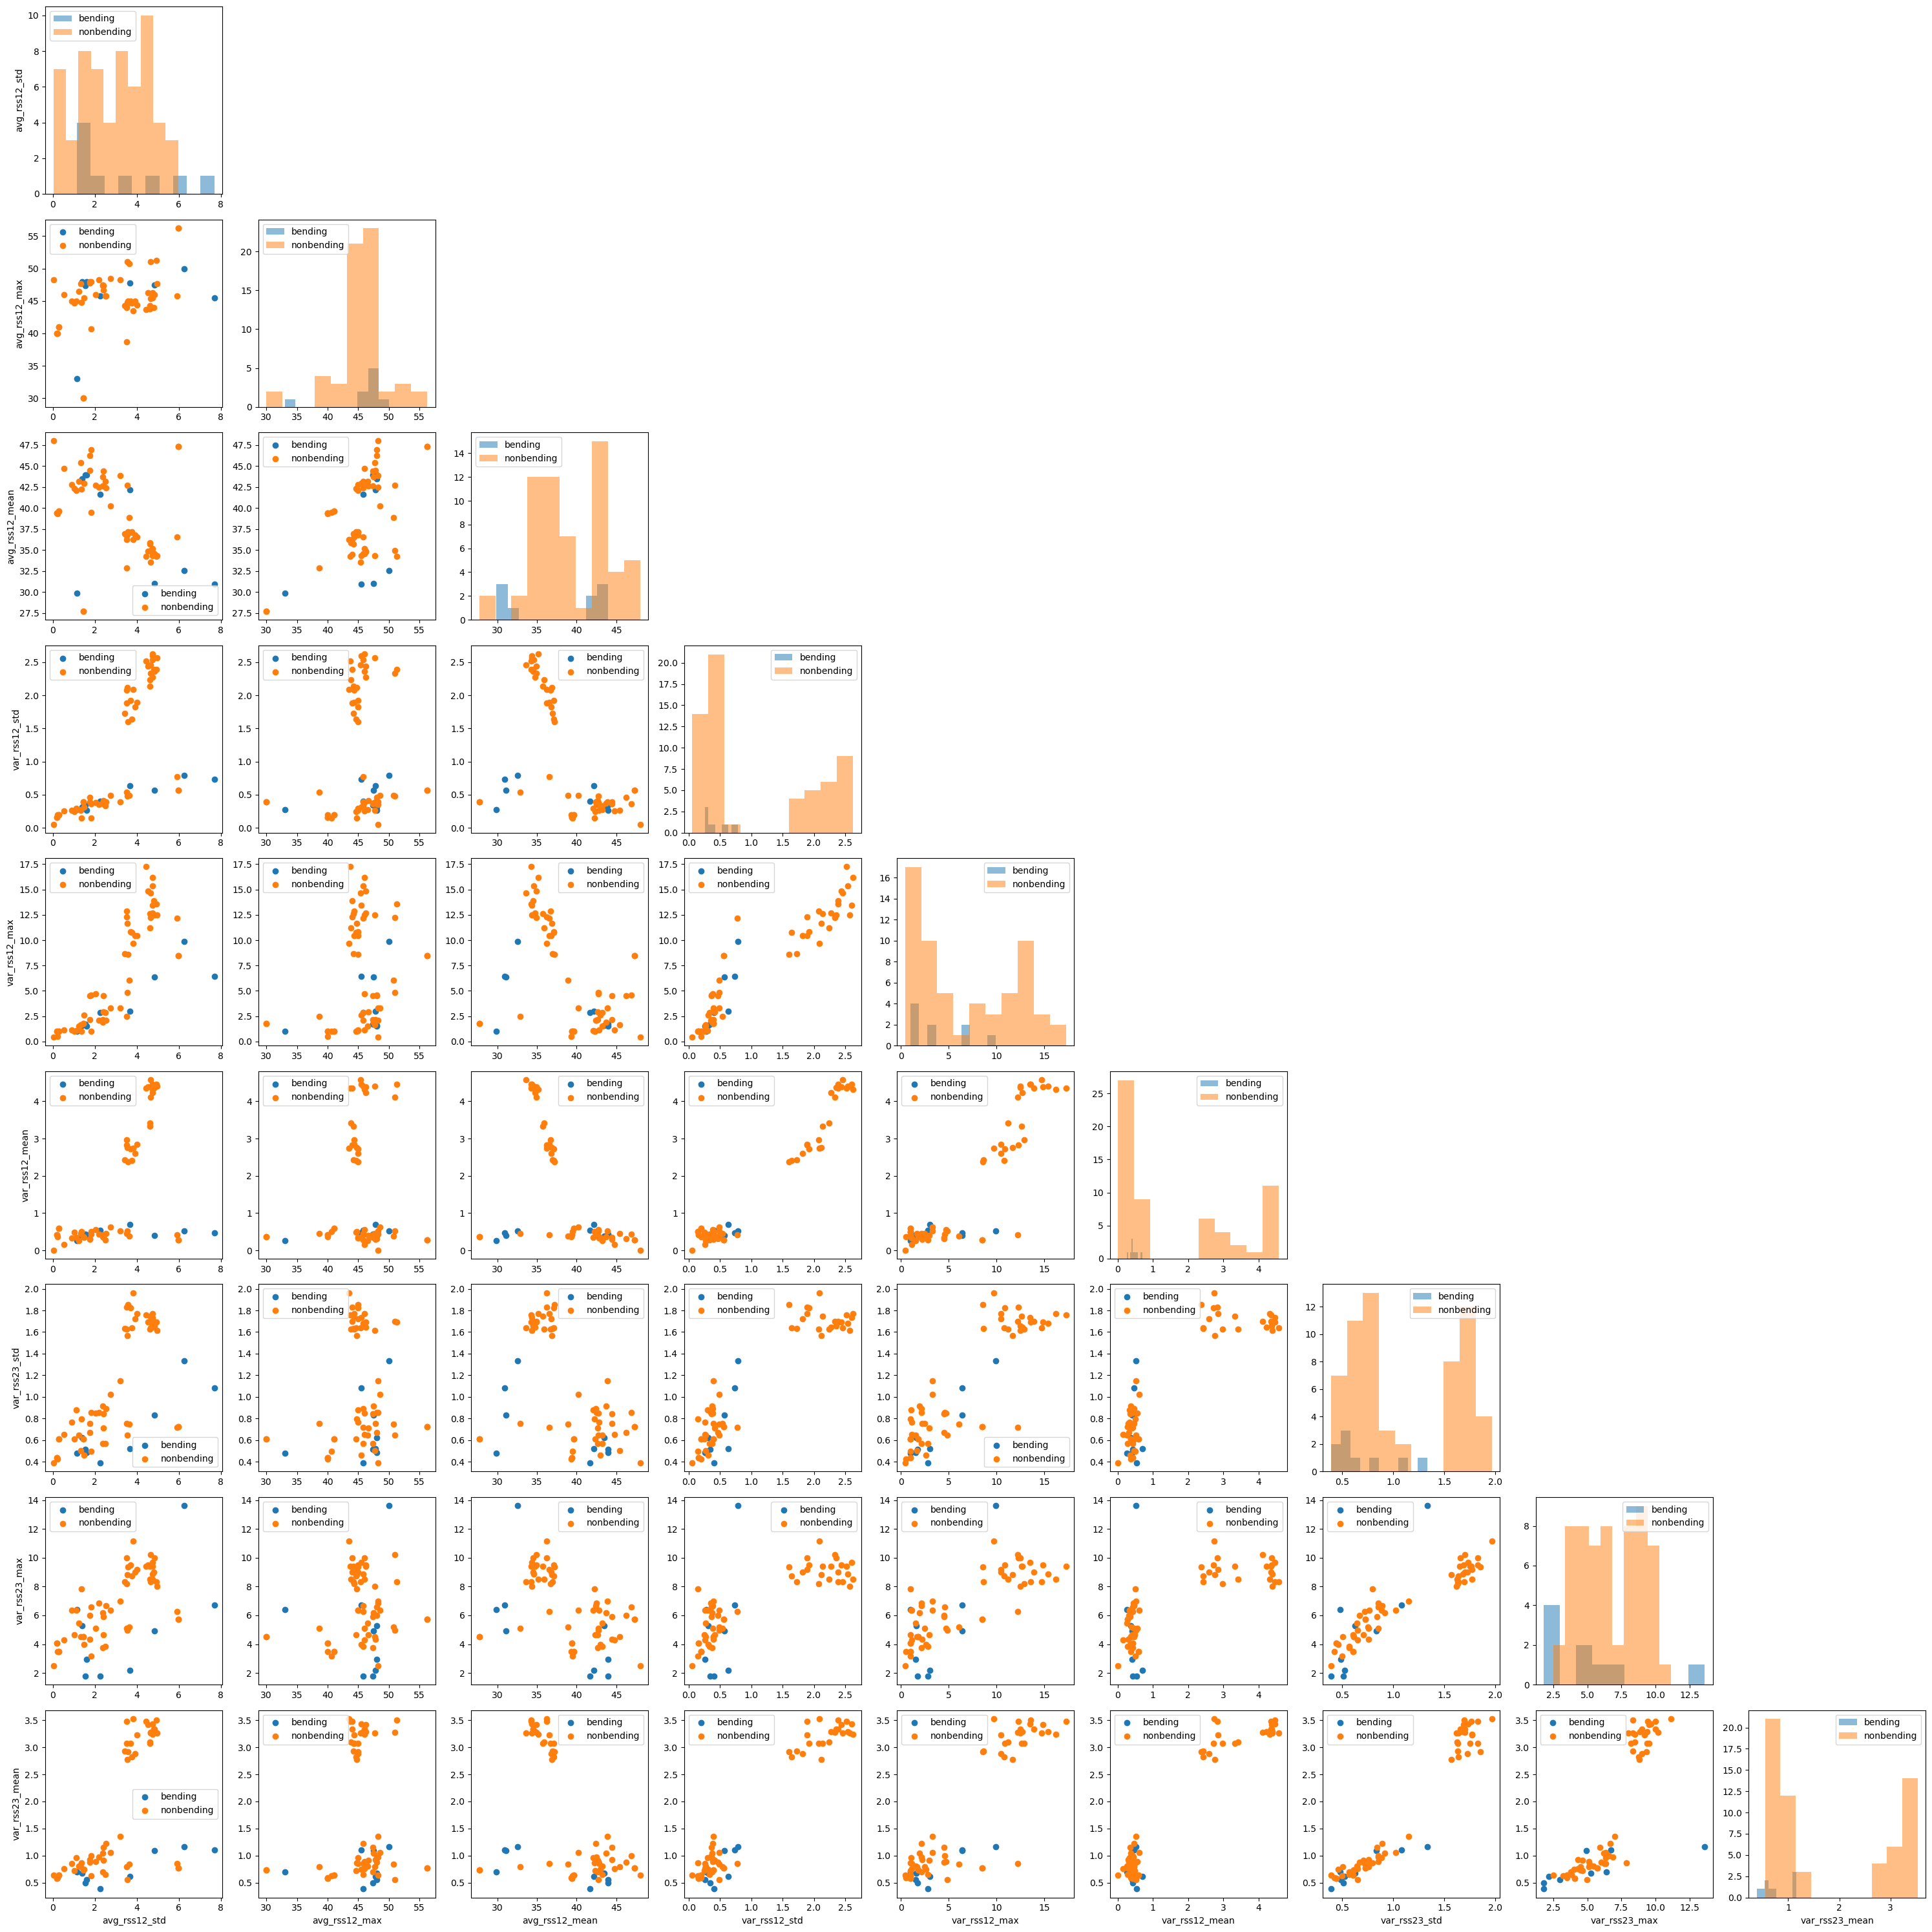

In [9]:
# pairwise scatterplot for each set of features
n = len(df_bending_train.columns)
fig, ax = plt.subplots(n, n, figsize=(30, 30))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(n):
    for j in range(n):
        # plot only lower triangle
        if i > j:
            ax[i, j].scatter(df_bending_train.iloc[:, j], df_bending_train.iloc[:, i], label='bending')
            ax[i, j].scatter(df_nonbending_train.iloc[:, j], df_nonbending_train.iloc[:, i], label='nonbending')
            ax[i, j].legend()
        # histograms on the diagonal
        elif i == j:
            ax[i, j].hist(df_bending_train.iloc[:, i], alpha=0.5, label='bending')
            ax[i, j].hist(df_nonbending_train.iloc[:, i], alpha=0.5, label='nonbending')
            ax[i, j].legend()
        else:
            ax[i, j].axis('off')
            
        # set labels on only the outer subplots
        if i == n-1:
            ax[i, j].set_xlabel(df_bending_train.columns[j])
        if j == 0:
            ax[i, j].set_ylabel(df_bending_train.columns[i])
            
plt.tight_layout()
plt.show()

#### 2.a.ii: scatter plot of half time series data

In [10]:
# repeat 1.c.ii but keep only upperhalf of each file
time_domain_features = []
folders = list(folders_files_map.keys())
instance_count = 1
# iterate through all files in each folder
for folder in folders:
    folder_path = os.path.join(base_dir, folder)
    for file in os.listdir(folder_path):
        if file.endswith('.csv'):
            file_path = os.path.join(folder_path, file)
            # print(instance_count, file_path)
            # read csv file and handle space separated file
            if 'bending2/dataset4' in file_path:
                curr_df = pd.read_csv(file_path, sep='\s+', skiprows=5, names=['time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23'])
            else:
                curr_df = pd.read_csv(file_path, skiprows=4).rename(columns={'# Columns: time': 'time'}) # format the df

            # keep only upper half of the df
            upper_half_rows = len(curr_df) // 2
            curr_df = curr_df.iloc[:upper_half_rows]
            
            curr_df.drop(columns='time', inplace=True)

            # create time domain feature dictionary to store features for instance
            curr_time_domain_feature = {'Instance': instance_count}
            # iterate through each column in current file
            for col in curr_df.columns:
                col_features = {
                    f'{col}_min': curr_df[col].min(),
                    f'{col}_max': curr_df[col].max(),
                    f'{col}_mean': curr_df[col].mean(),
                    f'{col}_median': curr_df[col].median(),
                    f'{col}_std': curr_df[col].std(),
                    f'{col}_q1': curr_df[col].quantile(0.25),
                    f'{col}_q3': curr_df[col].quantile(0.75),
                }
                # update current feature dict with current column features
                curr_time_domain_feature.update(col_features)
                
            # append current time domain feature to the features list
            time_domain_features.append(curr_time_domain_feature)
            # increment instance count
            instance_count += 1
# create time domain feature dataframe from the list of dictionary of features
features_df_half = pd.DataFrame(time_domain_features)
features_df_half

,Instance,avg_rss12_min,avg_rss12_max,avg_rss12_mean,avg_rss12_median,avg_rss12_std,avg_rss12_q1,avg_rss12_q3,var_rss12_min,var_rss12_max,...,avg_rss23_std,avg_rss23_q1,avg_rss23_q3,var_rss23_min,var_rss23_max,var_rss23_mean,var_rss23_median,var_rss23_std,var_rss23_q1,var_rss23_q3
0,1,36.67,45.00,43.486208,43.710,1.281976,42.3300,44.5000,0.0,1.30,...,4.271610,19.25,24.0000,0.00,2.28,0.524875,0.470,0.486847,0.00,0.8300
1,2,39.00,48.00,44.117042,45.000,1.359836,43.5000,45.0000,0.0,1.30,...,2.967487,21.75,24.2500,0.00,5.26,0.815417,0.710,0.718016,0.43,1.1200
2,3,33.75,47.75,43.278875,45.000,3.473355,42.0000,45.2500,0.0,3.00,...,1.650105,36.00,37.0000,0.00,1.53,0.640958,0.765,0.554542,0.00,1.2200
3,4,33.00,45.75,41.621208,42.330,3.118644,39.6525,44.2500,0.0,2.83,...,2.701406,28.50,31.5000,0.00,1.79,0.419083,0.430,0.411200,0.00,0.7100
4,5,38.00,42.33,40.946958,41.250,1.102963,40.3100,42.0000,0.0,1.22,...,1.212039,33.00,36.0000,0.00,1.50,0.589000,0.000,0.647856,0.00,1.3000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,84,20.33,44.50,34.036750,34.415,4.872880,30.7500,37.7500,0.0,13.47,...,3.083111,13.33,17.7500,0.47,8.41,3.543708,3.255,1.703098,2.28,4.7900
84,85,19.25,44.00,34.916792,35.375,4.634209,31.7500,38.2500,0.0,13.86,...,3.068400,13.73,18.0000,0.43,9.00,3.439917,3.200,1.737420,2.15,4.5075
85,86,24.33,44.00,34.920792,35.330,4.272282,32.2500,37.8125,0.0,14.82,...,3.103469,13.50,18.0000,0.00,9.18,3.430625,3.270,1.781928,2.16,4.5850
86,87,18.33,44.00,34.836458,35.750,4.869092,32.0000,38.6900,0.0,12.38,...,2.933582,14.25,18.2500,0.00,8.86,3.169625,2.870,1.647640,2.06,4.1200


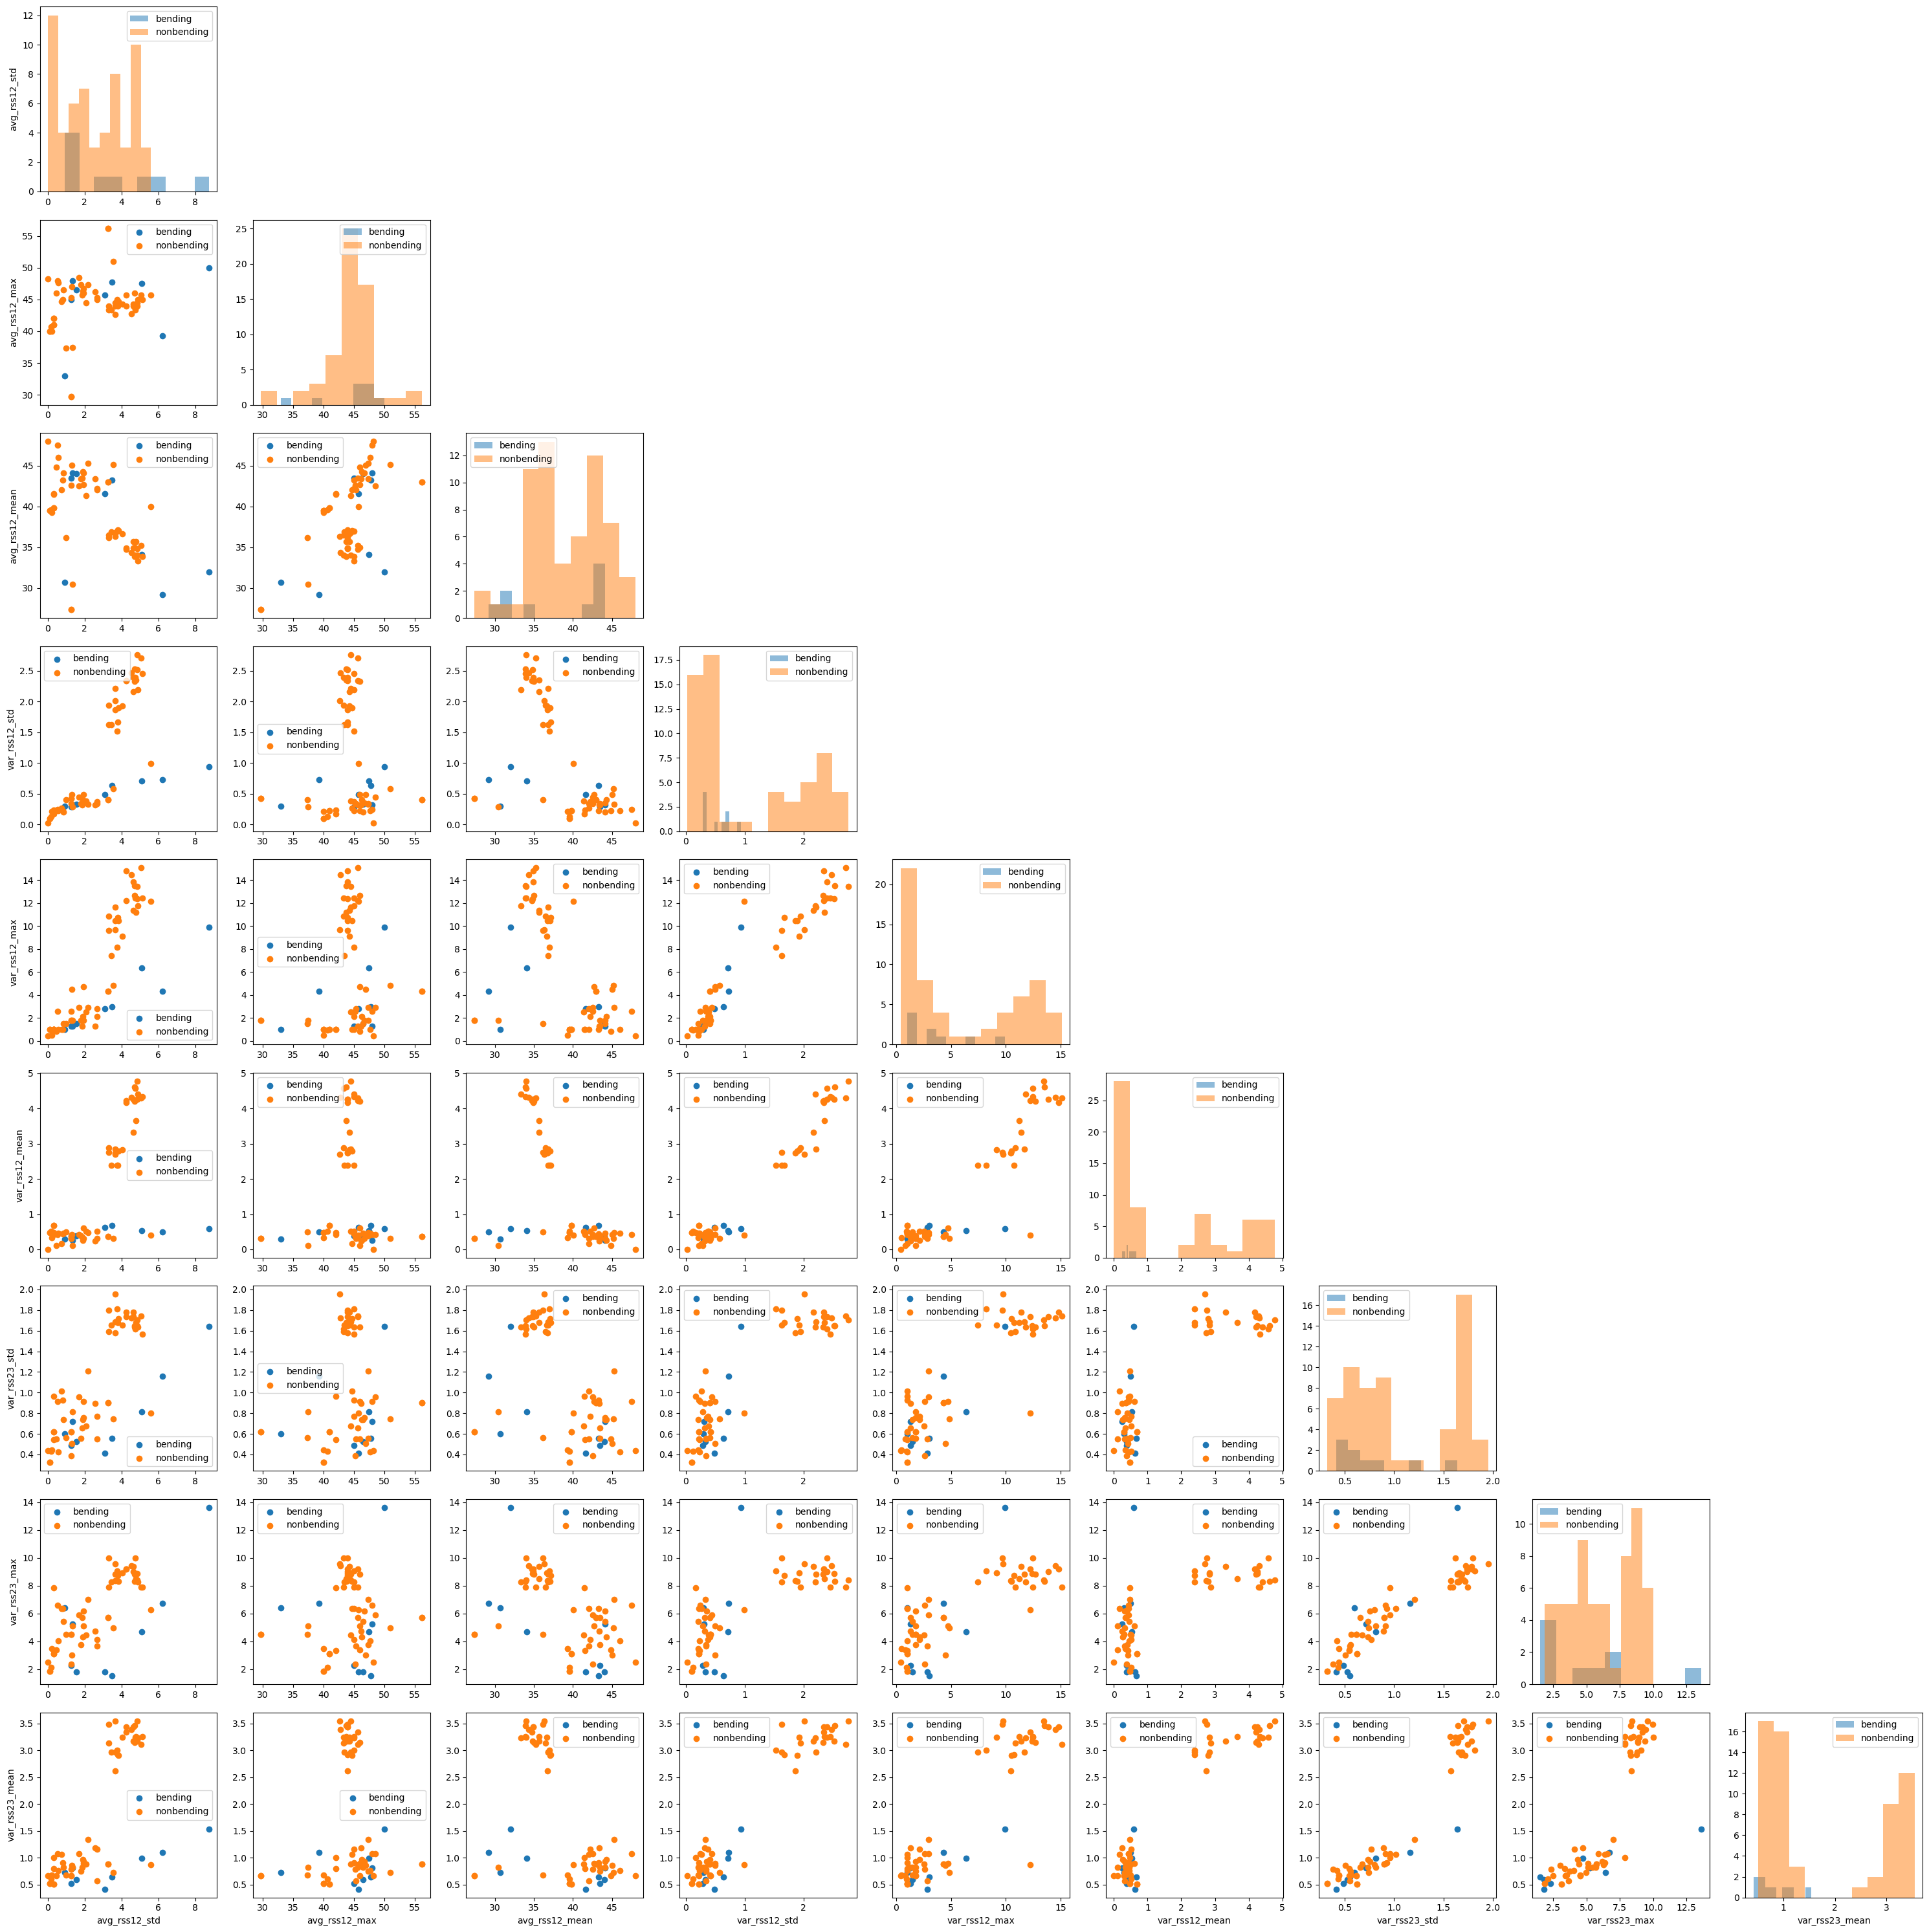

In [11]:
# repeat 2.a.i and only substitude feature_df with halved feature_df to get data ready for scatter plot
df_bending_train_half = features_df_half.loc[features_df_half['Instance'].isin(bending_train_instances), time_series_features]
df_nonbending_train_half = features_df_half.loc[features_df_half['Instance'].isin(nonbend_train_instances), time_series_features]

# repeat 2.a.ii to make scatterplot based on only half time series data
n = len(df_bending_train_half.columns)
fig, ax = plt.subplots(n, n, figsize=(30, 30))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(n):
    for j in range(n):
        # plot only lower triangle
        if i > j:
            ax[i, j].scatter(df_bending_train_half.iloc[:, j], df_bending_train_half.iloc[:, i], label='bending')
            ax[i, j].scatter(df_nonbending_train_half.iloc[:, j], df_nonbending_train_half.iloc[:, i], label='nonbending')
            ax[i, j].legend()
        # histograms on the diagonal
        elif i == j:
            ax[i, j].hist(df_bending_train_half.iloc[:, i], alpha=0.5, label='bending')
            ax[i, j].hist(df_nonbending_train_half.iloc[:, i], alpha=0.5, label='nonbending')
            ax[i, j].legend()
        else:
            ax[i, j].axis('off')
            
        # set labels on only the outer subplots
        if i == n-1:
            ax[i, j].set_xlabel(df_bending_train_half.columns[j])
        if j == 0:
            ax[i, j].set_ylabel(df_bending_train_half.columns[i])
            
plt.tight_layout()
plt.show()

There doesn't seem to be major differences from the results of 2.a.i - data distribution for each class and (graphical) separability are similar

#### 2.a.iii: break time series and fit logistic regressions with 5-fold cv to find optimal parameters

In [12]:
# helper function to spli the dataframe
def split_df(df, n_splits):
    # determine size of smaller dfs
    split_size = len(df) // n_splits
    remainder = len(df) % n_splits
    dfs = []
    # start from index 0
    start = 0
    for i in range(n_splits):
        if i < remainder:
            # assign extra rows to the leading splits
            end = start + split_size + 1
        else:
            end = start + split_size
        # construct splitted df
        dfs.append(df.iloc[start:end])
        # update start
        start = end
    return dfs

In [13]:
# helper function to find feature df for an instance based on number of splits
def find_features_instance(instance_df, l):
    # break current training instance into l equal length parts
    splitted_dfs = split_df(instance_df, l)
    # for each splitted df extract time domain features
    split_count = 1
    features_df_splits = pd.DataFrame() # feature df for current instance: 1 row and 6*3*l columns

    for splitted_df in splitted_dfs:
        # create time domain feature dictionary to store features for current instance
        time_domain_features = pd.DataFrame() # feature df for current instance: 1 row and 6*3*l columns

        # iterate through each column in current smaller df and find statistics
        curr_time_domain_feature = {}
        for col in splitted_df.columns:    
            col_features = {
                f'{col}_max_split{split_count}': splitted_df[col].max(),
                f'{col}_mean_split{split_count}': splitted_df[col].mean(),
                f'{col}_std_split{split_count}': splitted_df[col].std(),
            }
            # update current feature dict with current column features
            curr_time_domain_feature.update(col_features)
            
        curr_features_df_split = pd.DataFrame([curr_time_domain_feature]) # contains feature df for current splitted data
        features_df_splits = pd.concat([features_df_splits, curr_features_df_split], axis=1) # contains feature df for all splits

        # increment split count to keep track of feature column names
        split_count += 1
    
    return features_df_splits

In [14]:
# iterate through number of splits
for l in range(1, 21):
    features_df_splits= pd.DataFrame()  # feature df for current split: 88 rows and 6*7*l columns
    
    # read training instances
    for folder, test_files in folders_files_map.items():
        folder_path = os.path.join(base_dir, folder)
        all_files = os.listdir(folder_path)
        # read train data only
        train_files = [file for file in all_files if file.replace('.csv', '') not in test_files]
        for file_name in train_files:
            file_path = os.path.join(folder_path, file_name)
            if 'bending2/dataset4' in file_path:
                curr_df = pd.read_csv(file_path, sep='\s+', skiprows=5, names=['time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23'])
            else:
                curr_df = pd.read_csv(file_path, skiprows=4).rename(columns={'# Columns: time': 'time'})
            curr_df.drop(columns='time', inplace=True) # now curr_df would be only one train instance of 6 columns

            # call function to get feature df for current instance: 1 row and 6*7*l columns
            curr_features_df_splits = find_features_instance(curr_df, l)

            # add label to feature df of current instance
            if 'bending' in file_path:
                curr_features_df_splits['class'] = 'bending'
            else:
                curr_features_df_splits['class'] = 'other'

            # concatenate each instance to the end to get feature df of 69 rows and 6*3*l columns
            features_df_splits = pd.concat([features_df_splits, curr_features_df_splits], axis=0)
            
    # features_df_splits now has 69 rows and 6*7*l columns

    # logistic regression
    X = features_df_splits.drop(columns=['class'])
    encoder = LabelEncoder()
    y = encoder.fit_transform(features_df_splits['class'])
    logreg_model = LogisticRegression(max_iter=500)
    
    # 5-fold stratified (to handle imbalance) RFECV
    rfecv = RFECV(estimator=logreg_model, step=1, cv=StratifiedKFold(5), scoring='f1')
    rfecv.fit(X, y)

    # print evaluation metrics
    optimal_index = np.argmax(rfecv.cv_results_['mean_test_score'])
    optimal_score = rfecv.cv_results_['mean_test_score'][optimal_index]
    print(f"Optimal number of features for l={l}: {rfecv.n_features_}, with F1 score = {optimal_score}")
    important_features = X.columns[rfecv.support_]
    print(f"Important features for l={l}:")
    for feature in important_features:
        print(feature)
    print()

Optimal number of features for l=1: 8, with F1 score = 0.9753043478260869
Important features for l=1:
avg_rss12_mean_split1
var_rss12_max_split1
avg_rss13_max_split1
avg_rss13_mean_split1
avg_rss23_max_split1
avg_rss23_mean_split1
avg_rss23_std_split1
var_rss23_mean_split1

Optimal number of features for l=2: 1, with F1 score = 0.9692307692307693
Important features for l=2:
avg_rss23_mean_split1

Optimal number of features for l=3: 5, with F1 score = 0.9766153846153847
Important features for l=3:
var_rss12_max_split1
avg_rss13_mean_split1
avg_rss23_max_split1
avg_rss23_mean_split1
avg_rss23_mean_split3

Optimal number of features for l=4: 1, with F1 score = 0.9846153846153847
Important features for l=4:
avg_rss23_mean_split1

Optimal number of features for l=5: 1, with F1 score = 0.9766153846153847
Important features for l=5:
avg_rss23_mean_split1

Optimal number of features for l=6: 1, with F1 score = 0.9759197324414716
Important features for l=6:
avg_rss23_mean_split1

Optimal number

The right way to do cross validation is incorpating l as part of the cross validation because the value of l affects the feature extraction process and impacts the model performance. The wrong way could be doing cross validation independent of l. Performing feature importance selection before cross validation could also be the wrong way.

Here I choose the optimal l to be 4 and p to be 1 because this (l, p) gives the highest F1 score which is an important metric in our binary classification problem. There are other (l, p) achieving similar F-1 score, but I choose this particular set because its simplicity provides a lower chance for the model to overfit.

#### 2.a.iv: evaluation on training data

Confusion Matrix on Training Data:
[[ 7  2]
 [ 1 59]]
ROC AUC on Training Data: 0.9907407407407407


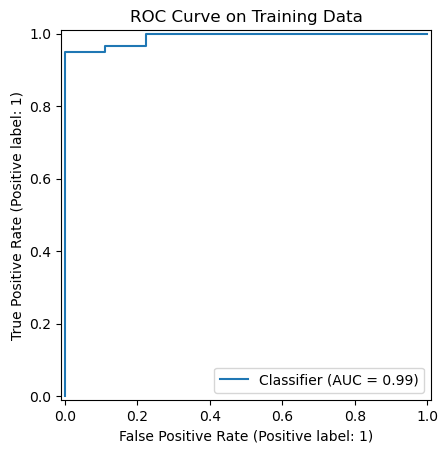

Optimization terminated successfully.
         Current function value: 0.086070
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   69
Model:                          Logit   Df Residuals:                       67
Method:                           MLE   Df Model:                            1
Date:                Fri, 01 Mar 2024   Pseudo R-squ.:                  0.7777
Time:                        18:20:55   Log-Likelihood:                -5.9388
converged:                       True   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 1.144e-10
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    22.7059      8.538      2.659      0.008       5.972      39

In [15]:
# refit logistic regression with optimal l=4, p=1
optimal_l = 4
features_df_splits = pd.DataFrame()

for folder, test_files in folders_files_map.items():
    folder_path = os.path.join(base_dir, folder)
    all_files = os.listdir(folder_path)
    # read train data only
    train_files = [file for file in all_files if file.replace('.csv', '') not in test_files]
    for file_name in train_files:
        file_path = os.path.join(folder_path, file_name)
        if 'bending2/dataset4' in file_path:
            curr_df = pd.read_csv(file_path, sep='\s+', skiprows=5, names=['time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23'])
        else:
            curr_df = pd.read_csv(file_path, skiprows=4).rename(columns={'# Columns: time': 'time'})
        curr_df.drop(columns='time', inplace=True) # now curr_df would be only one train instance of 6 columns

        # call function to get feature df for current instance: 1 row and 6*3*l columns
        curr_features_df_splits = find_features_instance(curr_df, l=optimal_l)

        # add label to feature df of current instance
        if 'bending' in file_path:
            curr_features_df_splits['class'] = 'bending'
        else:
            curr_features_df_splits['class'] = 'other'

        # concatenate each instance to the end to get feature df of 69 rows and 6*7*l columns
        features_df_splits = pd.concat([features_df_splits, curr_features_df_splits], axis=0)

# logistic regression
X_train = features_df_splits[['avg_rss23_mean_split1']]
encoder = LabelEncoder()
y_train = encoder.fit_transform(features_df_splits['class'])
logreg_model_optimal = LogisticRegression(max_iter=500).fit(X_train, y_train)

y_pred_train = logreg_model_optimal.predict(X_train)
# confusion matrix
conf_matrix = confusion_matrix(y_train, y_pred_train)
print("Confusion Matrix on Training Data:")
print(conf_matrix)

# ROC AUC
y_pred_prob_train = logreg_model_optimal.predict_proba(X_train)[:, 1]
roc_auc = roc_auc_score(y_train, y_pred_prob_train)
print(f"ROC AUC on Training Data: {roc_auc}")
# plot ROC curve
RocCurveDisplay.from_predictions(y_train, y_pred_prob_train)
plt.title('ROC Curve on Training Data')
plt.show()

# p value for predictors using statsmodel
X_const = sm.add_constant(X_train)
logreg_model_sm = sm.Logit(y_train, X_const).fit()
print(logreg_model_sm.summary())

#### 2.a.v: evalution on test data

Accuracy Score on Test Data: 0.9473684210526315
Confusion Matrix on Testing Data:
[[ 3  1]
 [ 0 15]]
ROC AUC on Testing Data: 0.9


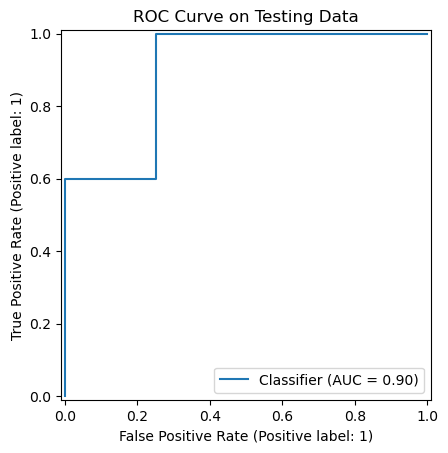

In [16]:
# use test data with l=4 and p=1
features_df_splits = pd.DataFrame()
for folder, test_files in folders_files_map.items():
    folder_path = os.path.join(base_dir, folder)
    all_files = os.listdir(folder_path)
    # read test data only
    train_files = [file for file in all_files if file.replace('.csv', '') in test_files]
    for file_name in train_files:
        file_path = os.path.join(folder_path, file_name)
        if 'bending2/dataset4' in file_path:
            curr_df = pd.read_csv(file_path, sep='\s+', skiprows=5, names=['time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23'])
        else:
            curr_df = pd.read_csv(file_path, skiprows=4).rename(columns={'# Columns: time': 'time'})
        curr_df.drop(columns='time', inplace=True) # now curr_df would be only one train instance of 6 columns

        # call function to get feature df for current instance: 1 row and 6*7*l columns
        curr_features_df_splits = find_features_instance(curr_df, l=optimal_l)

        # add label to feature df of current instance
        if 'bending' in file_path:
            curr_features_df_splits['class'] = 'bending'
        else:
            curr_features_df_splits['class'] = 'other'

        # concatenate each instance to the end to get feature df of 19 rows and 6*3*l columns
        features_df_splits = pd.concat([features_df_splits, curr_features_df_splits], axis=0)

# buil test X and y
X_test = features_df_splits[['avg_rss23_mean_split1']]
y_test = encoder.transform(features_df_splits['class'])
    
y_pred_test = logreg_model_optimal.predict(X_test)

# accuracy score
accuracy = accuracy_score(y_test, y_pred_test)
print(f"Accuracy Score on Test Data: {accuracy}")
# confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix on Testing Data:")
print(conf_matrix)

# ROC AUC
y_pred_prob_test = logreg_model_optimal.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_prob_test)
print(f"ROC AUC on Testing Data: {roc_auc}")
# plot ROC curve
RocCurveDisplay.from_predictions(y_test, y_pred_prob_test)
plt.title('ROC Curve on Testing Data')
plt.show()

Accuracy score for test data is about 0.03 lower than the best accuracy score in cross validation, and AUC ROC is about 10% lower compared to the training one.

#### 2.a.vi: well separated class and instability

Yes, the classes is well separated to cause instability when training the logistic regression. Parameters grow close to infinity and cause an error unless an early stopping (a limit on max_iterm) is set.

#### 2.a.vii: class imbalance and case-control sampling

The confusion matrix demonstrates imbalanced classes as the number of true positives and the number of true negatives differ quite significantly while fp and fn are small.

Confusion Matrix on Balanced Training Data:
[[57  3]
 [ 2 58]]
ROC AUC on Training Data: 0.9977777777777778


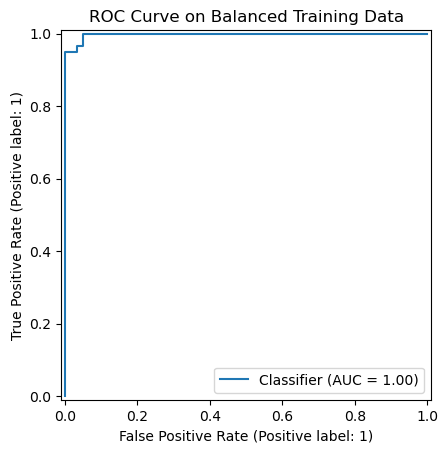


Confusion Matrix on Testing Data:
[[ 3  1]
 [ 2 13]]
ROC AUC on Testing Data: 0.9


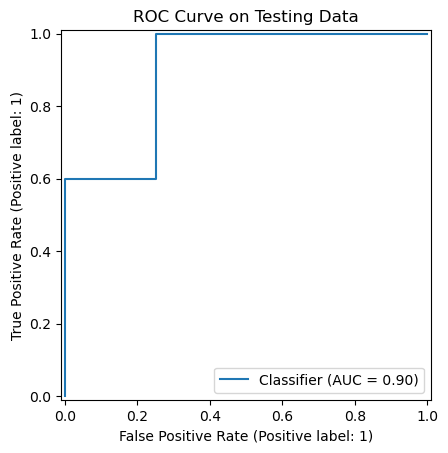

In [17]:
# use SMOTE to handle class imbalance and retrain the model
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
# logistic regression
logreg_model_balanced = LogisticRegression(max_iter=500)
logreg_model_balanced.fit(X_train_smote, y_train_smote)

# evaluation on smote training data
y_pred_train_smote = logreg_model_balanced.predict(X_train_smote)
# confusion matrix
conf_matrix = confusion_matrix(y_train_smote, y_pred_train_smote)
print("Confusion Matrix on Balanced Training Data:")
print(conf_matrix)
# ROC AUC
y_pred_prob_train_smote = logreg_model_balanced.predict_proba(X_train_smote)[:, 1]
roc_auc = roc_auc_score(y_train_smote, y_pred_prob_train_smote)
print(f"ROC AUC on Training Data: {roc_auc}")
# plot ROC curve
RocCurveDisplay.from_predictions(y_train_smote, y_pred_prob_train_smote)
plt.title('ROC Curve on Balanced Training Data')
plt.show()

# evaluation on smote testing data
print()
y_pred_test = logreg_model_balanced.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix on Testing Data:")
print(conf_matrix)

y_pred_prob_test = logreg_model_balanced.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_prob_test)
print(f"ROC AUC on Testing Data: {roc_auc}")

RocCurveDisplay.from_predictions(y_test, y_pred_prob_test)
plt.title('ROC Curve on Testing Data')
plt.show()

### b: binary classification with l1-penalized logistic regression

#### b.i:logistic regression with l1 regularization

In [18]:
# iterate through number of splits
for l in range(1, 21):
    features_df_splits = pd.DataFrame()  # feature df for current split: 88 rows and 6*7*l columns
    
    # read training instances
    for folder, test_files in folders_files_map.items():
        folder_path = os.path.join(base_dir, folder)
        all_files = os.listdir(folder_path)
        # read train data only
        train_files = [file for file in all_files if file.replace('.csv', '') not in test_files]
        for file_name in train_files:
            file_path = os.path.join(folder_path, file_name)
            if 'bending2/dataset4' in file_path:
                curr_df = pd.read_csv(file_path, sep='\s+', skiprows=5, names=['time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23'])
            else:
                curr_df = pd.read_csv(file_path, skiprows=4).rename(columns={'# Columns: time': 'time'})
            curr_df.drop(columns='time', inplace=True) # now curr_df would be only one train instance of 6 columns

            # call function to get feature df for current instance: 1 row and 6*7*l columns
            curr_features_df_splits = find_features_instance(curr_df, l)

            # add label to feature df of current instance
            if 'bending' in file_path:
                curr_features_df_splits['class'] = 'bending'
            else:
                curr_features_df_splits['class'] = 'other'

            # concatenate each instance to the end to get feature df of 69 rows and 6*3*l columns
            features_df_splits = pd.concat([features_df_splits, curr_features_df_splits], axis=0)

    # prepare X and y: X is standardized
    X = features_df_splits.drop(columns=['class'])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    encoder = LabelEncoder()
    y = encoder.fit_transform(features_df_splits['class'])

    # lasso cv
    logreg_cv = LogisticRegressionCV(Cs=10, cv=StratifiedKFold(5), penalty='l1', solver='liblinear', max_iter=500, scoring='f1')
    logreg_cv.fit(X_scaled, y)

    # report cv results
    optimal_C = logreg_cv.C_[0]
    optimal_C_index = np.where(logreg_cv.Cs_ == optimal_C)[0][0]
    mean_f1_score = np.mean(logreg_cv.scores_[1][:, optimal_C_index])
    print(f"Optimal C value for l={l}: {optimal_C}, with f-1 score of {mean_f1_score}")

Optimal C value for l=1: 0.3593813663804626, with f-1 score of 0.9753043478260869
Optimal C value for l=2: 0.3593813663804626, with f-1 score of 0.9584335664335665
Optimal C value for l=3: 0.3593813663804626, with f-1 score of 0.9679197324414716
Optimal C value for l=4: 0.3593813663804626, with f-1 score of 0.9679197324414716
Optimal C value for l=5: 2.782559402207126, with f-1 score of 0.9766153846153847
Optimal C value for l=6: 166.81005372000558, with f-1 score of 0.9759197324414716
Optimal C value for l=7: 2.782559402207126, with f-1 score of 0.9679197324414716
Optimal C value for l=8: 0.3593813663804626, with f-1 score of 0.9692307692307693
Optimal C value for l=9: 0.3593813663804626, with f-1 score of 0.9692307692307693
Optimal C value for l=10: 0.3593813663804626, with f-1 score of 0.9612307692307693
Optimal C value for l=11: 21.54434690031882, with f-1 score of 0.9846153846153847
Optimal C value for l=12: 2.782559402207126, with f-1 score of 0.9846153846153847
Optimal C value f

A max training F1 score of 0.992 is achieved for l=19, c=2.7825 with 10 features

#### b.ii: l1 penalized vs. variable select using p-values

In [19]:
# first, train the optimal l and c with l1 penalized model
optimal_l = 19
optimal_C = 2.7825
features_df_splits = pd.DataFrame()

for folder, test_files in folders_files_map.items():
    folder_path = os.path.join(base_dir, folder)
    all_files = os.listdir(folder_path)
    # read train data only
    train_files = [file for file in all_files if file.replace('.csv', '') not in test_files]
    for file_name in train_files:
        file_path = os.path.join(folder_path, file_name)
        if 'bending2/dataset4' in file_path:
            curr_df = pd.read_csv(file_path, sep='\s+', skiprows=5, names=['time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23'])
        else:
            curr_df = pd.read_csv(file_path, skiprows=4).rename(columns={'# Columns: time': 'time'})
        curr_df.drop(columns='time', inplace=True) # now curr_df would be only one train instance of 6 columns

        # call function to get feature df for current instance: 1 row and 6*3*l columns
        curr_features_df_splits = find_features_instance(curr_df, l=optimal_l)

        # add label to feature df of current instance
        if 'bending' in file_path:
            curr_features_df_splits['class'] = 'bending'
        else:
            curr_features_df_splits['class'] = 'other'

        # concatenate each instance to the end to get feature df of 69 rows and 6*7*l columns
        features_df_splits = pd.concat([features_df_splits, curr_features_df_splits], axis=0)

# logistic regression with l1 penalty
X_train = features_df_splits.drop(columns='class')
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
encoder = LabelEncoder()
y_train = encoder.fit_transform(features_df_splits['class'])
logreg_model_l1_optimal = LogisticRegression(C=optimal_C, penalty='l1', solver='liblinear', max_iter=500).fit(X_train_scaled_df, y_train)

Accuracy Score on Test Data: 0.9473684210526315
Confusion Matrix on Testing Data:
[[ 3  1]
 [ 0 15]]
ROC AUC on Testing Data: 0.8333333333333334


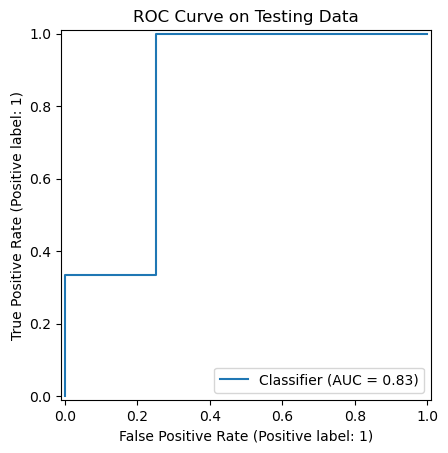

In [20]:
# then, test the optimal l1 penalized model performance on test data
features_df_splits = pd.DataFrame()
for folder, test_files in folders_files_map.items():
    folder_path = os.path.join(base_dir, folder)
    all_files = os.listdir(folder_path)
    # read test data only
    train_files = [file for file in all_files if file.replace('.csv', '') in test_files]
    for file_name in train_files:
        file_path = os.path.join(folder_path, file_name)
        if 'bending2/dataset4' in file_path:
            curr_df = pd.read_csv(file_path, sep='\s+', skiprows=5, names=['time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23'])
        else:
            curr_df = pd.read_csv(file_path, skiprows=4).rename(columns={'# Columns: time': 'time'})
        curr_df.drop(columns='time', inplace=True) # now curr_df would be only one train instance of 6 columns

        # call function to get feature df for current instance: 1 row and 6*7*l columns
        curr_features_df_splits = find_features_instance(curr_df, l=optimal_l)

        # add label to feature df of current instance
        if 'bending' in file_path:
            curr_features_df_splits['class'] = 'bending'
        else:
            curr_features_df_splits['class'] = 'other'

        # concatenate each instance to the end to get feature df of 19 rows and 6*3*l columns
        features_df_splits = pd.concat([features_df_splits, curr_features_df_splits], axis=0)

# buil test X and y
X_test = features_df_splits.drop(columns='class')
X_test_scaled = scaler.transform(X_test)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_train.columns)
y_test = encoder.transform(features_df_splits['class'])

y_pred_test = logreg_model_l1_optimal.predict(X_test_scaled_df)

# accuracy score
accuracy = accuracy_score(y_test, y_pred_test)
print(f"Accuracy Score on Test Data: {accuracy}")
# confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix on Testing Data:")
print(conf_matrix)

# ROC AUC
y_pred_prob_test = logreg_model_l1_optimal.predict_proba(X_test_scaled_df)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_prob_test)
print(f"ROC AUC on Testing Data: {roc_auc}")
# plot ROC curve
RocCurveDisplay.from_predictions(y_test, y_pred_prob_test)
plt.title('ROC Curve on Testing Data')
plt.show()

Comparison: The rfe variable selection model performs slighly better, but the overall performance is quite similar between the two models: they have the same accuracy score, same confusion matrix, but l1-penalized model has a slightly lower roc auc score. However, l-1 penalized model is generally easier to implement because l1 regularization inherently selects the feautre so that we don't need the manual feature selection process as in rfe variable selection model pipeline

### c: multiclass classification

#### 2.c.i: l1 penalized multinomial regression model

In [21]:
# iterate through number of splits
for l in range(1, 21):
    features_df_splits = pd.DataFrame()  # feature df for current split: 88 rows and 6*7*l columns
    
    # read training instances
    for folder, test_files in folders_files_map.items():
        folder_path = os.path.join(base_dir, folder)
        all_files = os.listdir(folder_path)
        # read train data only
        train_files = [file for file in all_files if file.replace('.csv', '') not in test_files]
        for file_name in train_files:
            file_path = os.path.join(folder_path, file_name)
            if 'bending2/dataset4' in file_path:
                curr_df = pd.read_csv(file_path, sep='\s+', skiprows=5, names=['time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23'])
            else:
                curr_df = pd.read_csv(file_path, skiprows=4).rename(columns={'# Columns: time': 'time'})
            curr_df.drop(columns='time', inplace=True) # now curr_df would be only one train instance of 6 columns

            # call function to get feature df for current instance: 1 row and 6*7*l columns
            curr_features_df_splits = find_features_instance(curr_df, l)

            # add label to feature df of current instance using folder name without trailing number
            activity_label = ''.join([char for char in folder if not char.isdigit()])
            curr_features_df_splits['class'] = activity_label

            # concatenate each instance to the end to get feature df of 69 rows and 6*3*l columns
            features_df_splits = pd.concat([features_df_splits, curr_features_df_splits], axis=0)

    # prepare X and y: X is standardized
    X = features_df_splits.drop(columns='class')
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    encoder = LabelEncoder()
    y = encoder.fit_transform(features_df_splits['class'])

    # lasso cv
    logreg_cv_multinom = LogisticRegressionCV(Cs=10,
                                     cv=StratifiedKFold(5), 
                                     penalty='l1',
                                     solver='saga',
                                     multi_class='multinomial',
                                     max_iter=5000,
                                     scoring='f1_weighted')
    logreg_cv_multinom.fit(X_scaled, y)

    # report cv results
    optimal_C = logreg_cv_multinom.C_[0]
    optimal_C_index = np.where(logreg_cv_multinom.Cs_ == optimal_C)[0][0]
    mean_f1_score = np.mean(logreg_cv_multinom.scores_[1][:, optimal_C_index])
    print(f"Optimal C value for l={l}: {optimal_C}, with weighted f-1 score of {mean_f1_score}")

Optimal C value for l=1: 2.782559402207126, with weighted f-1 score of 0.8818942961800105
Optimal C value for l=2: 0.3593813663804626, with weighted f-1 score of 0.8652328623757196
Optimal C value for l=3: 2.782559402207126, with weighted f-1 score of 0.8463553113553115
Optimal C value for l=4: 2.782559402207126, with weighted f-1 score of 0.832443746729461
Optimal C value for l=5: 2.782559402207126, with weighted f-1 score of 0.832613814756672
Optimal C value for l=6: 21.54434690031882, with weighted f-1 score of 0.7913553113553113
Optimal C value for l=7: 21.54434690031882, with weighted f-1 score of 0.8163160648874934
Optimal C value for l=8: 0.3593813663804626, with weighted f-1 score of 0.7775405546834119
Optimal C value for l=9: 21.54434690031882, with weighted f-1 score of 0.7740476190476191
Optimal C value for l=10: 0.3593813663804626, with weighted f-1 score of 0.777906855049712
Optimal C value for l=11: 0.3593813663804626, with weighted f-1 score of 0.7874646781789639
Optimal

A max training weighted F1 (account for multiclass classification problem) score of 0.882 is achieved for l=1, c=2.7825 with 13 features:
avg_rss12_max_split1,
avg_rss12_mean_split1,
avg_rss12_std_split1,
var_rss12_max_split1,
var_rss12_mean_split1,
avg_rss13_max_split1,
avg_rss13_mean_split1,
avg_rss13_std_split1,
var_rss13_max_split1,
var_rss13_std_split1,
avg_rss23_max_split1,
avg_rss23_mean_split1,
avg_rss23_std_split1

In [22]:
# train optimal multinomial model
optimal_l = 10
optimal_C = 2.7825
features_df_splits = pd.DataFrame()

for folder, test_files in folders_files_map.items():
    folder_path = os.path.join(base_dir, folder)
    all_files = os.listdir(folder_path)
    # read train data only
    train_files = [file for file in all_files if file.replace('.csv', '') not in test_files]
    for file_name in train_files:
        file_path = os.path.join(folder_path, file_name)
        if 'bending2/dataset4' in file_path:
            curr_df = pd.read_csv(file_path, sep='\s+', skiprows=5, names=['time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23'])
        else:
            curr_df = pd.read_csv(file_path, skiprows=4).rename(columns={'# Columns: time': 'time'})
        curr_df.drop(columns='time', inplace=True) # now curr_df would be only one train instance of 6 columns

        # call function to get feature df for current instance: 1 row and 6*3*l columns
        curr_features_df_splits = find_features_instance(curr_df, l=optimal_l)

        # add label to feature df of current instance using folder name without trailing number
        activity_label = ''.join([char for char in folder if not char.isdigit()])
        curr_features_df_splits['class'] = activity_label

        # concatenate each instance to the end to get feature df of 69 rows and 6*7*l columns
        features_df_splits = pd.concat([features_df_splits, curr_features_df_splits], axis=0)

# logistic regression with l1 penalty
X_train = features_df_splits.drop(columns='class')
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
encoder = LabelEncoder()
y_train = encoder.fit_transform(features_df_splits['class'])

multinom_model_optimal = LogisticRegression(C=optimal_C, penalty='l1', solver='saga', multi_class='multinomial', max_iter=5000)
multinom_model_optimal.fit(X_train_scaled_df, y_train)

LogisticRegression(C=2.7825, max_iter=5000, multi_class='multinomial',
                   penalty='l1', solver='saga')

Accuracy Score on Test Data: 0.8421052631578947
Confusion Matrix on Testing Data:
[[3 0 0 1 0 0]
 [0 3 0 0 0 0]
 [0 0 3 0 0 0]
 [0 0 0 2 1 0]
 [0 0 0 1 2 0]
 [0 0 0 0 0 3]]
ROC AUC on Testing Data: 0.9826388888888888


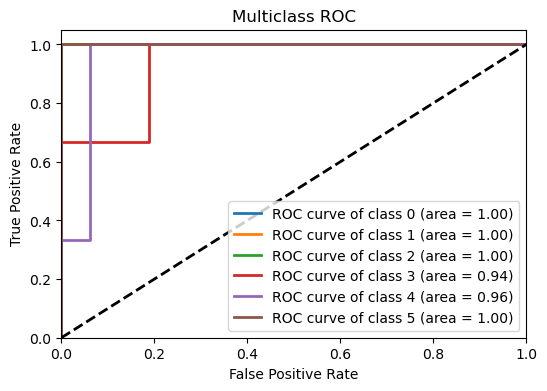

In [23]:
# test and evaluate
features_df_splits = pd.DataFrame()
for folder, test_files in folders_files_map.items():
    folder_path = os.path.join(base_dir, folder)
    all_files = os.listdir(folder_path)
    # read test data only
    train_files = [file for file in all_files if file.replace('.csv', '') in test_files]
    for file_name in train_files:
        file_path = os.path.join(folder_path, file_name)
        if 'bending2/dataset4' in file_path:
            curr_df = pd.read_csv(file_path, sep='\s+', skiprows=5, names=['time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23'])
        else:
            curr_df = pd.read_csv(file_path, skiprows=4).rename(columns={'# Columns: time': 'time'})
        curr_df.drop(columns='time', inplace=True) # now curr_df would be only one train instance of 6 columns

        # call function to get feature df for current instance: 1 row and 6*7*l columns
        curr_features_df_splits = find_features_instance(curr_df, l=optimal_l)

        # add label to feature df of current instance using folder name without trailing number
        activity_label = ''.join([char for char in folder if not char.isdigit()])
        curr_features_df_splits['class'] = activity_label

        # concatenate each instance to the end to get feature df of 19 rows and 6*3*l columns
        features_df_splits = pd.concat([features_df_splits, curr_features_df_splits], axis=0)

# buil test X and y
X_test = features_df_splits.drop(columns='class')
X_test_scaled = scaler.transform(X_test)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_train.columns)
y_test = encoder.transform(features_df_splits['class'])

y_pred_test = multinom_model_optimal.predict(X_test_scaled_df)

# accuracy score
accuracy = accuracy_score(y_test, y_pred_test)
print(f"Accuracy Score on Test Data: {accuracy}")
# confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix on Testing Data:")
print(conf_matrix)

# ROC AUC for multiclass: binarize labels
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
y_pred_prob_test = multinom_model_optimal.predict_proba(X_test_scaled_df)

roc_auc = roc_auc_score(y_test_binarized, y_pred_prob_test, multi_class='ovr', average='macro')
print(f"ROC AUC on Testing Data: {roc_auc}")

# plot roc curve for all classes
n_classes = y_test_binarized.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_prob_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(6, 4))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC')
plt.legend(loc="lower right")
plt.show()

#### 2.c.ii: naive bayes classifier for multiclass: gaussian prior

In [24]:
# iterate through number of splits
for l in range(1, 21):
    features_df_splits = pd.DataFrame()  # feature df for current split: 88 rows and 6*7*l columns
    
    # read training instances
    for folder, test_files in folders_files_map.items():
        folder_path = os.path.join(base_dir, folder)
        all_files = os.listdir(folder_path)
        # read train data only
        train_files = [file for file in all_files if file.replace('.csv', '') not in test_files]
        for file_name in train_files:
            file_path = os.path.join(folder_path, file_name)
            if 'bending2/dataset4' in file_path:
                curr_df = pd.read_csv(file_path, sep='\s+', skiprows=5, names=['time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23'])
            else:
                curr_df = pd.read_csv(file_path, skiprows=4).rename(columns={'# Columns: time': 'time'})
            curr_df.drop(columns='time', inplace=True) # now curr_df would be only one train instance of 6 columns

            # call function to get feature df for current instance: 1 row and 6*7*l columns
            curr_features_df_splits = find_features_instance(curr_df, l)

            # add label to feature df of current instance using folder name without trailing number
            activity_label = ''.join([char for char in folder if not char.isdigit()])
            curr_features_df_splits['class'] = activity_label

            # concatenate each instance to the end to get feature df of 69 rows and 6*3*l columns
            features_df_splits = pd.concat([features_df_splits, curr_features_df_splits], axis=0)

    # prepare X and y: X is standardized
    X = features_df_splits.drop(columns=['class'])
    encoder = LabelEncoder()
    y = encoder.fit_transform(features_df_splits['class'])

    # gaussian naive bayes
    gnb = GaussianNB()
    # cross validation and evaluation
    cv_scores = cross_val_score(gnb, X, y, cv=StratifiedKFold(5), scoring='f1_weighted')
    mean_f1_score = np.mean(cv_scores)
    print(f"Mean weighted f-1 score for l={l}: {mean_f1_score}")

Mean weighted f-1 score for l=1: 0.8408738880167451
Mean weighted f-1 score for l=2: 0.8150000000000001
Mean weighted f-1 score for l=3: 0.7718027210884355
Mean weighted f-1 score for l=4: 0.8443537414965986
Mean weighted f-1 score for l=5: 0.8293354264782836
Mean weighted f-1 score for l=6: 0.7787362637362637
Mean weighted f-1 score for l=7: 0.8109471480900051
Mean weighted f-1 score for l=8: 0.8081632653061224
Mean weighted f-1 score for l=9: 0.7965934065934065
Mean weighted f-1 score for l=10: 0.7274175824175824
Mean weighted f-1 score for l=11: 0.7800313971742543
Mean weighted f-1 score for l=12: 0.7630612244897959
Mean weighted f-1 score for l=13: 0.741156462585034
Mean weighted f-1 score for l=14: 0.739738356881214
Mean weighted f-1 score for l=15: 0.7668812140240713
Mean weighted f-1 score for l=16: 0.7754526425954997
Mean weighted f-1 score for l=17: 0.7160989010989012
Mean weighted f-1 score for l=18: 0.7623076923076922
Mean weighted f-1 score for l=19: 0.7737310308738882
Mean

In [25]:
# select optimal l = 1 and train gaussian nb
optimal_l = 1
features_df_splits = pd.DataFrame()

for folder, test_files in folders_files_map.items():
    folder_path = os.path.join(base_dir, folder)
    all_files = os.listdir(folder_path)
    # read train data only
    train_files = [file for file in all_files if file.replace('.csv', '') not in test_files]
    for file_name in train_files:
        file_path = os.path.join(folder_path, file_name)
        if 'bending2/dataset4' in file_path:
            curr_df = pd.read_csv(file_path, sep='\s+', skiprows=5, names=['time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23'])
        else:
            curr_df = pd.read_csv(file_path, skiprows=4).rename(columns={'# Columns: time': 'time'})
        curr_df.drop(columns='time', inplace=True) # now curr_df would be only one train instance of 6 columns

        # call function to get feature df for current instance: 1 row and 6*3*l columns
        curr_features_df_splits = find_features_instance(curr_df, l=optimal_l)

        # add label to feature df of current instance using folder name without trailing number
        activity_label = ''.join([char for char in folder if not char.isdigit()])
        curr_features_df_splits['class'] = activity_label

        # concatenate each instance to the end to get feature df of 69 rows and 6*7*l columns
        features_df_splits = pd.concat([features_df_splits, curr_features_df_splits], axis=0)

# naive bayes with guassian prior
X_train = features_df_splits.drop(columns='class')
encoder = LabelEncoder()
y_train = encoder.fit_transform(features_df_splits['class'])
gnb_model_optimal = GaussianNB().fit(X_train, y_train)

Accuracy Score on Test Data: 0.9473684210526315
Confusion Matrix on Testing Data:
[[4 0 0 0 0 0]
 [0 3 0 0 0 0]
 [0 0 3 0 0 0]
 [0 0 0 3 0 0]
 [0 0 0 1 2 0]
 [0 0 0 0 0 3]]
ROC AUC on Testing Data: 0.9826388888888888


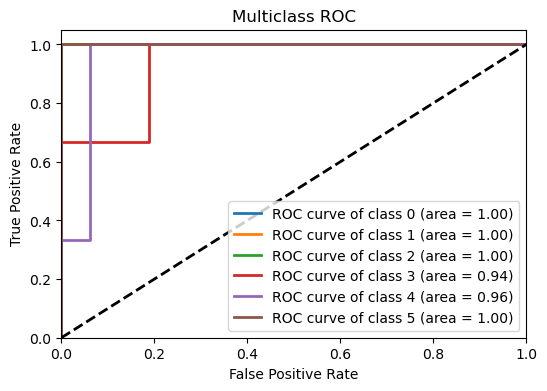

In [26]:
# test and evaluate
features_df_splits = pd.DataFrame()
for folder, test_files in folders_files_map.items():
    folder_path = os.path.join(base_dir, folder)
    all_files = os.listdir(folder_path)
    # read test data only
    train_files = [file for file in all_files if file.replace('.csv', '') in test_files]
    for file_name in train_files:
        file_path = os.path.join(folder_path, file_name)
        if 'bending2/dataset4' in file_path:
            curr_df = pd.read_csv(file_path, sep='\s+', skiprows=5, names=['time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23'])
        else:
            curr_df = pd.read_csv(file_path, skiprows=4).rename(columns={'# Columns: time': 'time'})
        curr_df.drop(columns='time', inplace=True) # now curr_df would be only one train instance of 6 columns

        # call function to get feature df for current instance: 1 row and 6*7*l columns
        curr_features_df_splits = find_features_instance(curr_df, l=optimal_l)

        # add label to feature df of current instance using folder name without trailing number
        activity_label = ''.join([char for char in folder if not char.isdigit()])
        curr_features_df_splits['class'] = activity_label

        # concatenate each instance to the end to get feature df of 19 rows and 6*3*l columns
        features_df_splits = pd.concat([features_df_splits, curr_features_df_splits], axis=0)

# buil test X and y
X_test = features_df_splits.drop(columns='class')
y_test = encoder.transform(features_df_splits['class'])

y_pred_test = gnb_model_optimal.predict(X_test)

# accuracy score
accuracy = accuracy_score(y_test, y_pred_test)
print(f"Accuracy Score on Test Data: {accuracy}")
# confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix on Testing Data:")
print(conf_matrix)

# ROC AUC for multiclass: binarize labels
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
y_pred_prob_test = multinom_model_optimal.predict_proba(X_test_scaled_df)

roc_auc = roc_auc_score(y_test_binarized, y_pred_prob_test, multi_class='ovr', average='macro')
print(f"ROC AUC on Testing Data: {roc_auc}")

# plot roc curve for all classes
n_classes = y_test_binarized.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_prob_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(6, 4))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC')
plt.legend(loc="lower right")
plt.show()

#### 2.c.ii: naive bayes classifier for multiclass: multinomial prior

In [27]:
# iterate through number of splits
for l in range(1, 21):
    features_df_splits = pd.DataFrame()  # feature df for current split: 88 rows and 6*7*l columns
    
    # read training instances
    for folder, test_files in folders_files_map.items():
        folder_path = os.path.join(base_dir, folder)
        all_files = os.listdir(folder_path)
        # read train data only
        train_files = [file for file in all_files if file.replace('.csv', '') not in test_files]
        for file_name in train_files:
            file_path = os.path.join(folder_path, file_name)
            if 'bending2/dataset4' in file_path:
                curr_df = pd.read_csv(file_path, sep='\s+', skiprows=5, names=['time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23'])
            else:
                curr_df = pd.read_csv(file_path, skiprows=4).rename(columns={'# Columns: time': 'time'})
            curr_df.drop(columns='time', inplace=True) # now curr_df would be only one train instance of 6 columns

            # call function to get feature df for current instance: 1 row and 6*7*l columns
            curr_features_df_splits = find_features_instance(curr_df, l)

            # add label to feature df of current instance using folder name without trailing number
            activity_label = ''.join([char for char in folder if not char.isdigit()])
            curr_features_df_splits['class'] = activity_label

            # concatenate each instance to the end to get feature df of 69 rows and 6*3*l columns
            features_df_splits = pd.concat([features_df_splits, curr_features_df_splits], axis=0)

    # prepare X and y: X is standardized
    X = features_df_splits.drop(columns=['class'])
    encoder = LabelEncoder()
    y = encoder.fit_transform(features_df_splits['class'])

    # multinomial naive bayes
    mnb = MultinomialNB()
    # cross validation and evaluation
    cv_scores = cross_val_score(mnb, X, y, cv=StratifiedKFold(5), scoring='f1_weighted')
    mean_f1_score = np.mean(cv_scores)
    print(f"Mean weighted f-1 score for l={l}: {mean_f1_score}")

Mean weighted f-1 score for l=1: 0.7454421768707483
Mean weighted f-1 score for l=2: 0.7536054421768708
Mean weighted f-1 score for l=3: 0.7597278911564626
Mean weighted f-1 score for l=4: 0.7616326530612245
Mean weighted f-1 score for l=5: 0.7873809523809523
Mean weighted f-1 score for l=6: 0.7902380952380953
Mean weighted f-1 score for l=7: 0.7997278911564625
Mean weighted f-1 score for l=8: 0.7644897959183673
Mean weighted f-1 score for l=9: 0.8261564625850341
Mean weighted f-1 score for l=10: 0.7621428571428572
Mean weighted f-1 score for l=11: 0.7955337519623233
Mean weighted f-1 score for l=12: 0.7578231292517007
Mean weighted f-1 score for l=13: 0.8107718472004187
Mean weighted f-1 score for l=14: 0.7940136054421769
Mean weighted f-1 score for l=15: 0.7628048142333856
Mean weighted f-1 score for l=16: 0.7632993197278911
Mean weighted f-1 score for l=17: 0.76421768707483
Mean weighted f-1 score for l=18: 0.7318367346938776
Mean weighted f-1 score for l=19: 0.7356253270538984
Mean

In [28]:
# train mnb with optimal l=9
# select optimal l = 1 and train gaussian nb
optimal_l = 9
features_df_splits = pd.DataFrame()

for folder, test_files in folders_files_map.items():
    folder_path = os.path.join(base_dir, folder)
    all_files = os.listdir(folder_path)
    # read train data only
    train_files = [file for file in all_files if file.replace('.csv', '') not in test_files]
    for file_name in train_files:
        file_path = os.path.join(folder_path, file_name)
        if 'bending2/dataset4' in file_path:
            curr_df = pd.read_csv(file_path, sep='\s+', skiprows=5, names=['time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23'])
        else:
            curr_df = pd.read_csv(file_path, skiprows=4).rename(columns={'# Columns: time': 'time'})
        curr_df.drop(columns='time', inplace=True) # now curr_df would be only one train instance of 6 columns

        # call function to get feature df for current instance: 1 row and 6*3*l columns
        curr_features_df_splits = find_features_instance(curr_df, l=optimal_l)

        # add label to feature df of current instance using folder name without trailing number
        activity_label = ''.join([char for char in folder if not char.isdigit()])
        curr_features_df_splits['class'] = activity_label

        # concatenate each instance to the end to get feature df of 69 rows and 6*7*l columns
        features_df_splits = pd.concat([features_df_splits, curr_features_df_splits], axis=0)

# naive bayes with guassian prior
X_train = features_df_splits.drop(columns='class')
encoder = LabelEncoder()
y_train = encoder.fit_transform(features_df_splits['class'])
mnb_model_optimal = MultinomialNB().fit(X_train, y_train)

Accuracy Score on Test Data: 0.8421052631578947
Confusion Matrix on Testing Data:
[[4 0 0 0 0 0]
 [0 3 0 0 0 0]
 [0 0 2 1 0 0]
 [0 0 0 2 1 0]
 [0 0 0 1 2 0]
 [0 0 0 0 0 3]]
ROC AUC on Testing Data: 0.9826388888888888


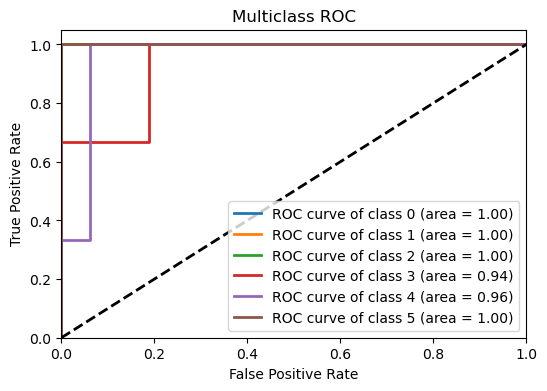

In [29]:
# test optimal mnb performance
# test and evaluate
features_df_splits = pd.DataFrame()
for folder, test_files in folders_files_map.items():
    folder_path = os.path.join(base_dir, folder)
    all_files = os.listdir(folder_path)
    # read test data only
    train_files = [file for file in all_files if file.replace('.csv', '') in test_files]
    for file_name in train_files:
        file_path = os.path.join(folder_path, file_name)
        if 'bending2/dataset4' in file_path:
            curr_df = pd.read_csv(file_path, sep='\s+', skiprows=5, names=['time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23'])
        else:
            curr_df = pd.read_csv(file_path, skiprows=4).rename(columns={'# Columns: time': 'time'})
        curr_df.drop(columns='time', inplace=True) # now curr_df would be only one train instance of 6 columns

        # call function to get feature df for current instance: 1 row and 6*7*l columns
        curr_features_df_splits = find_features_instance(curr_df, l=optimal_l)

        # add label to feature df of current instance using folder name without trailing number
        activity_label = ''.join([char for char in folder if not char.isdigit()])
        curr_features_df_splits['class'] = activity_label

        # concatenate each instance to the end to get feature df of 19 rows and 6*3*l columns
        features_df_splits = pd.concat([features_df_splits, curr_features_df_splits], axis=0)

# buil test X and y
X_test = features_df_splits.drop(columns='class')
y_test = encoder.transform(features_df_splits['class'])

y_pred_test = mnb_model_optimal.predict(X_test)

# accuracy score
accuracy = accuracy_score(y_test, y_pred_test)
print(f"Accuracy Score on Test Data: {accuracy}")
# confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix on Testing Data:")
print(conf_matrix)

# ROC AUC for multiclass: binarize labels
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
y_pred_prob_test = multinom_model_optimal.predict_proba(X_test_scaled_df)

roc_auc = roc_auc_score(y_test_binarized, y_pred_prob_test, multi_class='ovr', average='macro')
print(f"ROC AUC on Testing Data: {roc_auc}")

# plot roc curve for all classes
n_classes = y_test_binarized.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_prob_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(6, 4))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC')
plt.legend(loc="lower right")
plt.show()

Naive Bayes classifier with gaussian prior performs better than Naive Bayes classifier with multinomial prior. While both model produce equally good ROC AUC, the one with gaussian prior has a testing accuracy of 0.94, which is about 0.1 higher than the one with multinomial prior, and it also has a perfect confusion matrix.

#### 2.c.iii: best performing method

Among l1-penalized multinomial regressor, naive bayes classifier with gaussian prior, and naive bayes classifier with multinomial prior, naive bayes classifier with gaussian prior has the best performance with testing accuracy of 0.94, a perfect confusion matrix, and a nearly-perfect roc auc. Possible reasons can be its robustness to irrelevant features as well as the feauture meeting the model's assumption of gaussian distribution

## 3. ISLR 4.8.3

For section 4.4.1, if we release the assumption of equal variance across all classes, we have a posterior of:
$$p_k(x) = \frac{\pi_k \frac{1}{\sqrt{2\pi\sigma_k^2}} \exp\left(-\frac{1}{2\sigma_k^2}(x - \mu_k)^2\right)}{\sum_{l=1}^K \pi_l \frac{1}{\sqrt{2\pi\sigma_l^2}} \exp\left(-\frac{1}{2\sigma_l^2}(x - \mu_l)^2\right)}$$
To maximimize this posterior with respect to k, we can focus on only the numerator:
$$f_k(x) = \pi_k \frac{1}{\sqrt{2\pi\sigma_k^2}} \exp\left(-\frac{1}{2\sigma_k^2}(x - \mu_k)^2\right)$$
We then take the logarithm and simplfy to obtain:
$$
f_k(x) = \log(\pi_k) + \log\left(\frac{1}{\sqrt{2\pi\sigma_k}}\right) - \frac{1}{2\sigma_k^2}(x - \mu_k)^2
  = \log(\pi_k) + \log\left(\frac{1}{\sqrt{2\pi\sigma_k}}\right) - \frac{x^2}{2\sigma_k^2} + \frac{x\mu_k}{\sigma_k^2} - \frac{\mu_k^2}{2\sigma_k^2}
$$
In this function, $\frac{x^2}{2\sigma_k^2}$ is the dominant term, which is quadratic. Therefore, this bayes classifier is essentially optimizing a quadratic log likelihood function and is thus quadratic, not linear.

## 3. ISLR 4.8.7

Translating this problem to a bayes binary classification, we have 2 classes: issue dividend (Y), not issue dividend (N). We also have the percent profit X being the random varibale. For X in class Y, it has normal density of $N(\mu_Y=10, \sigma^2=36)$; and for X in class N, it has normal density of $N(\mu_N=0, \sigma^2=36)$. We want to find the probability of a new point $x=4$ belonging to class Y, and we are given the prior probability of class Y: $\pi_Y=0.8$. Using bayes' theorem of gaussian prior, we are essential calcualting $p(Y|x)$ as below:
$$
p(Y|x) = \frac{p(x|Y)p(Y)}{p(x|Y)p(Y) + p(x|N)p(N)}
$$
under gaussian assumption and simplify due to equal variance:
$$
p(Y|x) = \frac{\pi_Y \frac{1}{\sqrt{2\pi\sigma^2}} e^{\frac{-(x-\mu_Y)^2}{2\sigma^2}}}
               {\pi_Y \frac{1}{\sqrt{2\pi\sigma^2}} e^{\frac{-(x-\mu_Y)^2}{2\sigma^2}} +
                \pi_N \frac{1}{\sqrt{2\pi\sigma^2}} e^{\frac{-(x-\mu_N)^2}{2\sigma^2}}}
        = \frac{\pi_Y e^{\frac{-(x-\mu_Y)^2}{2\sigma^2}}}
               {\pi_Y e^{\frac{-(x-\mu_Y)^2}{2\sigma^2}} +
                \pi_N e^{\frac{-(x-\mu_N)^2}{2\sigma^2}}}
$$
, where $x=4$, $\pi_Y=0.8$, $\pi_N=0.2$, $\mu_Y=10$, $\mu_N=0$, $\sigma^2=36$, and plug in we get:
$$
p(Y|x) = \frac{0.8 * e^{\frac{-(4-10)^2}{2*36^2}}}
               {0.8 * e^{\frac{-(4-10)^2}{2*36^2}} +
                0.2 * e^{\frac{-(4-0)^2}{2*36^2}}}
        = 0.7519
$$
Thus, if a new company has last year's percetage profit of 4, the probability it will issue a dividend is 75.19%.